# Présentation Partie 6 - Sécurité et menaces

## Objectifs du sujet :
1. **Détection d'anomalies temps réel** durant l'ingestion  
2. **Analyse des logs** pour identifier dysfonctionnements  
3. **Évaluation drift modèle** et correction si nécessaire

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("PARTIE 6: SÉCURITÉ")
print("=" * 40)

PARTIE 6: SÉCURITÉ


## 1. Détection d'anomalies temps réel

In [20]:
# Génération de données d'ingestion simulées
def generate_simple_ingestion_data():
    timestamps = pd.date_range(start=datetime.now() - timedelta(hours=24), 
                              end=datetime.now(), freq='10min')
    data = []
    
    for timestamp in timestamps:
        # Volume normal: 100-200, anomalies: >500 ou <20
        if np.random.random() < 0.05:  # 5% anomalies
            volume = np.random.choice([np.random.randint(500, 1000), np.random.randint(0, 20)])
            is_anomaly = True
        else:
            volume = np.random.randint(100, 200)
            is_anomaly = False
        
        response_time = 150 if is_anomaly else np.random.randint(30, 80)
        error_rate = 0.1 if is_anomaly else np.random.uniform(0.001, 0.02)
        
        data.append({
            'timestamp': timestamp,
            'volume': volume,
            'response_time_ms': response_time,
            'error_rate': error_rate,
            'is_real_anomaly': is_anomaly
        })
    
    return pd.DataFrame(data)

# Génération des données
ingestion_data = generate_simple_ingestion_data()
print(f"{len(ingestion_data)} points générés (24h par tranches 10min)")
print(f"{ingestion_data['is_real_anomaly'].sum()} anomalies simulées")

145 points générés (24h par tranches 10min)
7 anomalies simulées


In [21]:
# Détection avec Isolation Forest
detector = IsolationForest(contamination=0.1, random_state=42)
scaler = StandardScaler()

# Features pour détection
features = ['volume', 'response_time_ms', 'error_rate']
X = ingestion_data[features]
X_scaled = scaler.fit_transform(X)

# Prédictions (-1 = anomalie)
predictions = detector.fit_predict(X_scaled)
ingestion_data['detected_anomaly'] = predictions == -1

# Évaluation simple
true_pos = ((ingestion_data['is_real_anomaly']) & (ingestion_data['detected_anomaly'])).sum()
false_pos = ((~ingestion_data['is_real_anomaly']) & (ingestion_data['detected_anomaly'])).sum()
detected_total = ingestion_data['detected_anomaly'].sum()

print(f"\nRÉSULTATS DÉTECTION:")
print(f"   Vraies anomalies détectées: {true_pos}")
print(f"   Faux positifs: {false_pos}")
print(f"   Total détecté: {detected_total}")
print(f"   Précision: {true_pos/max(detected_total,1):.2f}")


RÉSULTATS DÉTECTION:
   Vraies anomalies détectées: 7
   Faux positifs: 8
   Total détecté: 15
   Précision: 0.47


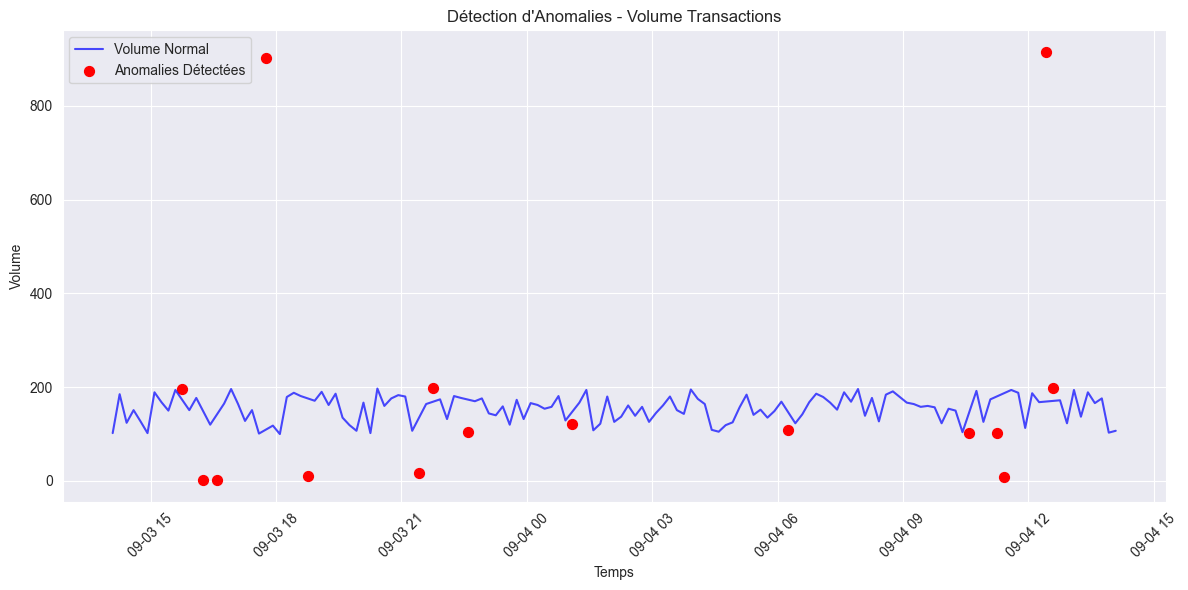

Système de détection d'anomalies opérationnel


In [22]:
# Graphique simple des anomalies
plt.figure(figsize=(12, 6))

# Volume avec anomalies marquées
normal_data = ingestion_data[~ingestion_data['detected_anomaly']]
anomaly_data = ingestion_data[ingestion_data['detected_anomaly']]

plt.plot(normal_data['timestamp'], normal_data['volume'], 'b-', alpha=0.7, label='Volume Normal')
plt.scatter(anomaly_data['timestamp'], anomaly_data['volume'], color='red', s=50, label='Anomalies Détectées')

plt.title('Détection d\'Anomalies - Volume Transactions')
plt.xlabel('Temps')
plt.ylabel('Volume')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Système de détection d'anomalies opérationnel")

## 2. Analyse des logs système

In [23]:
# Génération de logs simulés
def generate_simple_logs():
    timestamps = pd.date_range(start=datetime.now() - timedelta(hours=24), 
                              end=datetime.now(), freq='2min')
    logs = []
    
    attack_ips = ['192.168.1.100', '10.0.0.15', '203.0.113.42']
    
    for timestamp in timestamps:
        if np.random.random() < 0.95:  # 95% logs normaux
            level = 'INFO'
            message = 'Transaction processed successfully'
            is_malicious = False
            ip = f'192.168.1.{np.random.randint(2, 50)}'
        else:  # 5% incidents
            level = np.random.choice(['WARN', 'ERROR'])
            messages = [
                'Failed authentication attempt',
                'Rate limit exceeded',
                'SQL injection detected',
                'Suspicious transaction pattern'
            ]
            message = np.random.choice(messages)
            is_malicious = True
            ip = np.random.choice(attack_ips)
        
        logs.append({
            'timestamp': timestamp,
            'level': level,
            'message': message,
            'source_ip': ip,
            'is_malicious': is_malicious
        })
    
    return pd.DataFrame(logs)

# Génération et analyse
logs_data = generate_simple_logs()
print(f"{len(logs_data)} logs analysés (24h)")
print(f"{logs_data['is_malicious'].sum()} incidents détectés")

# Top IPs suspectes
malicious_ips = logs_data[logs_data['is_malicious']]['source_ip'].value_counts()
print(f"\nTOP IPs MALICIEUSES:")
for ip, count in malicious_ips.head(3).items():
    print(f"   {ip}: {count} incidents")

# Types d'incidents
incident_types = logs_data[logs_data['is_malicious']]['message'].value_counts()
print(f"\nTYPES D'INCIDENTS:")
for incident, count in incident_types.head(3).items():
    print(f"   • {incident}: {count}x")

721 logs analysés (24h)
36 incidents détectés

TOP IPs MALICIEUSES:
   10.0.0.15: 13 incidents
   203.0.113.42: 12 incidents
   192.168.1.100: 11 incidents

TYPES D'INCIDENTS:
   • Rate limit exceeded: 11x
   • Failed authentication attempt: 10x
   • Suspicious transaction pattern: 8x


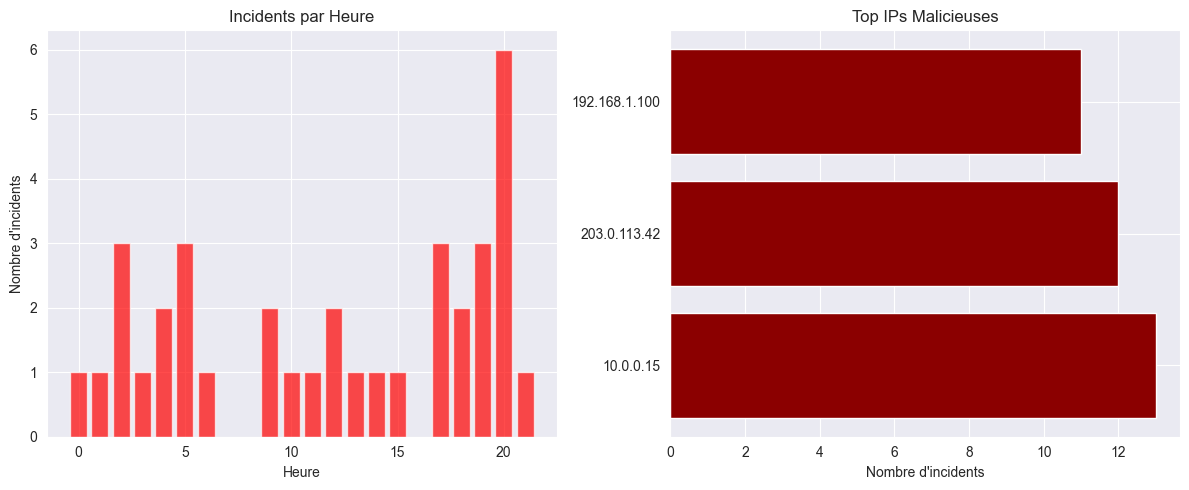

Analyse des logs terminée


In [24]:
# Graphique simple des incidents
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Incidents par heure
hourly_incidents = logs_data[logs_data['is_malicious']].groupby(
    logs_data['timestamp'].dt.hour).size()

ax1.bar(hourly_incidents.index, hourly_incidents.values, color='red', alpha=0.7)
ax1.set_title('Incidents par Heure')
ax1.set_xlabel('Heure')
ax1.set_ylabel('Nombre d\'incidents')

# Top IPs
ax2.barh(malicious_ips.head(5).index, malicious_ips.head(5).values, color='darkred')
ax2.set_title('Top IPs Malicieuses')
ax2.set_xlabel('Nombre d\'incidents')

plt.tight_layout()
plt.show()

print("Analyse des logs terminée")

## 3. Évaluation et correction du drift modèle

In [25]:
# Simulation simple du drift modèle
def simulate_simple_drift():
    weeks = range(0, 13)  # 13 semaines
    drift_data = []
    
    base_f1 = 0.88  # Performance initiale
    
    for week in weeks:
        # Dégradation progressive
        degradation = min(week * 0.02, 0.25)  # Max 25% dégradation
        current_f1 = base_f1 * (1 - degradation)
        
        # Score de drift (0 à 1)
        drift_score = min(week * 0.08, 1.0)
        
        # Besoin de réentraînement si F1 < 0.75
        needs_retraining = current_f1 < 0.75
        
        drift_data.append({
            'week': week,
            'f1_score': current_f1,
            'drift_score': drift_score,
            'needs_retraining': needs_retraining
        })
    
    return pd.DataFrame(drift_data)

# Génération données drift
drift_data = simulate_simple_drift()
print(f"Simulation drift sur {len(drift_data)} semaines")
print(f"F1 initial: {drift_data.iloc[0]['f1_score']:.3f}")
print(f"F1 final: {drift_data.iloc[-1]['f1_score']:.3f}")

# Premier seuil critique
critical_weeks = drift_data[drift_data['needs_retraining']]
if len(critical_weeks) > 0:
    first_critical = critical_weeks.iloc[0]
    print(f"Réentraînement requis dès semaine {first_critical['week']}")
else:
    print(f"Aucun réentraînement nécessaire")

Simulation drift sur 13 semaines
F1 initial: 0.880
F1 final: 0.669
Réentraînement requis dès semaine 8


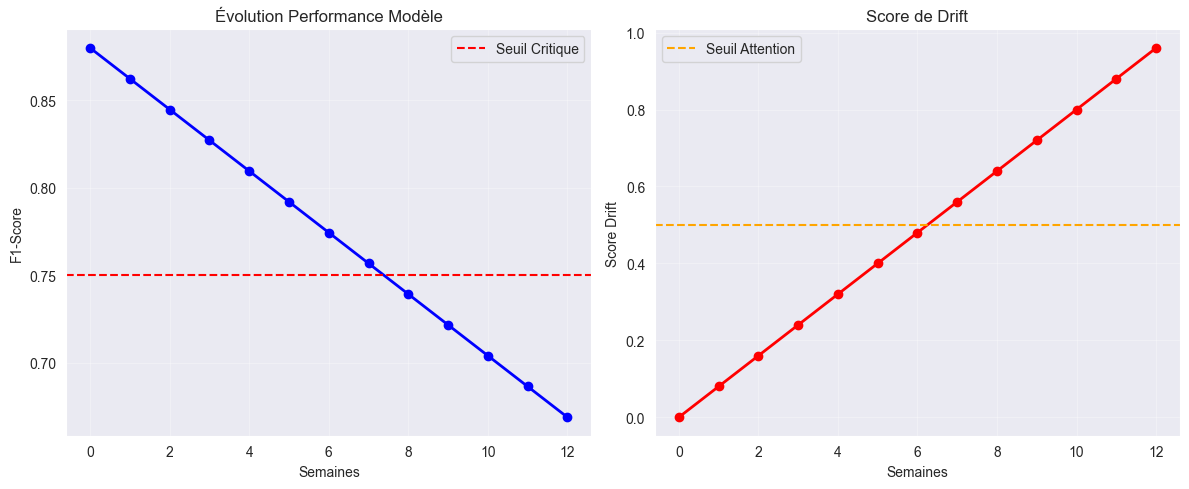

Évaluation drift terminée


In [26]:
# Graphique évolution drift
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Évolution F1-Score
ax1.plot(drift_data['week'], drift_data['f1_score'], 'b-o', linewidth=2)
ax1.axhline(y=0.75, color='red', linestyle='--', label='Seuil Critique')
ax1.set_title('Évolution Performance Modèle')
ax1.set_xlabel('Semaines')
ax1.set_ylabel('F1-Score')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Score de drift
ax2.plot(drift_data['week'], drift_data['drift_score'], 'r-o', linewidth=2)
ax2.axhline(y=0.5, color='orange', linestyle='--', label='Seuil Attention')
ax2.set_title('Score de Drift')
ax2.set_xlabel('Semaines')
ax2.set_ylabel('Score Drift')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Évaluation drift terminée")

In [27]:
# Stratégie de correction simple
def recommend_correction(drift_score, f1_score):
    if f1_score < 0.70:
        return "URGENT: Réentraînement complet requis"
    elif f1_score < 0.75:
        return "ATTENTION: Réentraînement planifié"
    elif drift_score > 0.5:
        return "Surveillance renforcée"
    else:
        return "Monitoring standard"

print("STRATÉGIES DE CORRECTION:")
print("=" * 28)

# Recommandations pour les semaines critiques
for idx, row in drift_data.iterrows():
    if row['week'] % 3 == 0 or row['needs_retraining']:  # Chaque 3 semaines ou critique
        recommendation = recommend_correction(row['drift_score'], row['f1_score'])
        print(f"Semaine {row['week']:2d}: {recommendation}")

print(f"\nRÉSUMÉ CORRECTION:")
total_retraining = drift_data['needs_retraining'].sum()
print(f"   Réentraînements nécessaires: {total_retraining}")
print(f"   Fréquence recommandée: Toutes les 4 semaines")
print(f"   Objectif: Maintenir F1 > 0.80")

print("\nSystème correction drift opérationnel")

STRATÉGIES DE CORRECTION:
Semaine  0: Monitoring standard
Semaine  3: Monitoring standard
Semaine  6: Monitoring standard
Semaine  8: ATTENTION: Réentraînement planifié
Semaine  9: ATTENTION: Réentraînement planifié
Semaine 10: ATTENTION: Réentraînement planifié
Semaine 11: URGENT: Réentraînement complet requis
Semaine 12: URGENT: Réentraînement complet requis

RÉSUMÉ CORRECTION:
   Réentraînements nécessaires: 5
   Fréquence recommandée: Toutes les 4 semaines
   Objectif: Maintenir F1 > 0.80

Système correction drift opérationnel
